# 🚀 다변수 입력 및 3D 착륙 위치 예측 미션

## "AI 드론의 고급 착륙 예측: 3D 좌표 학습하기"

### 📜 시나리오

이제는 드론이 3차원 공간에서 착륙해야 합니다.  
입력은 `(위도, 경도, 고도)`이고, 드론은 이 정보를 바탕으로 `(목표 X, Y, Z)` 좌표에 정확히 착륙해야 합니다.

단순한 회귀가 아닌, **3차원 벡터 예측 문제**로 확장됩니다.


### 🧪 실습 목표

- 다변수 입력 (3D 위치: 위도, 경도, 고도)
- 다차원 출력 (착륙 좌표: X, Y, Z)
- 신경망 순전파, 역전파 구현
- MSE 손실과 학습 시각화


### 📂 데이터 구성

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 입력: 위도, 경도, 고도 (예시 데이터 4개)
X = np.array([
    [10.0, 20.0, 100.0],
    [15.0, 25.0, 120.0],
    [12.0, 22.0, 110.0],
    [14.0, 24.0, 115.0],
])

# 출력: 착륙해야 할 3D 위치 (X, Y, Z)
y = np.array([
    [5.0,  3.0,  0.5],
    [6.5,  4.0,  0.8],
    [5.5,  3.5,  0.6],
    [6.2,  3.8,  0.7],
])

# 초기 가중치 및 편향 설정
np.random.seed(1) #실험의 재현성 확보용 
W1 = np.random.randn(3, 6)  # 입력 3 → 은닉 6 입력이 3 이다? 입력층(3차원: 위도, 경도, 고도) / 은닉층 6개로 가는 가중치 행렬 / 랜덤 정규 분포로 초기화 
b1 = np.zeros((1, 6)) #은닉층의 편향 / 뉴런 6개에 각각 1개씩 편향이 필요 (1, 6) 배열로 0으로 초기화 
W2 = np.random.randn(6, 3)  # 은닉 6 → 출력 3(착륙 좌표 X,Y,Z)
b2 = np.zeros((1, 3)) #출력층의 편향 

### 🔧 ReLU 활성화 함수

In [4]:
def relu(x):
    return np.maximum(0, x)
    #0보다 크면 그대로, 작으면 0 

def relu_grad(x):
    return (x>0).astype(float)
    #미분하면 x>0 일때는 1, 아니면 0
    #.astype(float) : boolean 값을 float로 바꿔줌. True -> 1.0/ False -> 0.0

    #이게 필요한 이유? 신경망 학습에서 역전파 할 때, ReLU함수의 미분값을 곱해줘야 비선형성 영향이 반영됨. 

### 🔍 순전파

In [5]:
def forward(X):
    global Z1, A1, Z2, y_pred #역전파 할때 필요. 
    Z1 = X @ W1 + b1 
    A1 = relu(Z1) #은닉층의 활성화 값. 비선형성을 주는단계 
    Z2 = A1 @ W2 + b2
    y_pred = Z2
    
    return y_pred 



### 🔄 역전파 및 경사하강법

In [6]:
#예측값과 실제값을 비교해서 오차(Loss)계산 
#오차를 기반으로 각 계층의 가중치와 편향에 대한 변화량(gradient)계산 
#학습률(lr)만큼 가중치와 편향을 업데이트 
def mse_loss(y_pred, y_true):
     return np.mean((y_pred - y_true)**2)

def backward(X, y_true, lr=0.001):
    global W1, b1, W2, b2
    m = X.shape[0] #샘플 수 

    #출령층 오차 -> 손실의 기울기 계산 
    dZ2 = (y_pred - y_true) / m #평균 제곱오차의 도함수는 2*(y_pred-y_true)지만 여기선 상수 2는 생략(학습률로 흡수 가능) / 출력층에서의 오차 신호를 의미  [4,3]
    dW2 = A1.T @ dZ2 #w2가 얼마나 바뀌어야 하는지를 나타냄.  A1.shape(4, 6) dZ2.shape = (4, 3) dW2.shape = (6,3) 은닉 6개 출력 3개 [6,4] @ [4,3] = [6,3]
    db2 = np.sum(dZ2, axis=0, keepdims=True) #각 샘플별 오차를 축방향(행별)로 다 더해서 편향 b2에 대한 기울기 계산 / 각 뉴런에 대해 모든 샘플의 오차를 더함.

    #은닉층 오차 
    dA1 = dZ2 @ W2.T
    dZ1 = dA1 * relu_grad(Z1)
    dW1 = X.T @ dZ1
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    #파라미터 업데이트/ 기울기 방향으로 파라미터를 조금씩 줄여서 손실 줄이기 
    W2 -= lr * dW2
    b2 -= lr * db2
    W1 -= lr * dW1
    b1 -= lr * db1




## 다시 한 번 개념 정리
**1. MSE(Mean Squared Error) : 샘플마다 오차를 계산한 뒤 평균을 내는 방식**
- 역전파에서 손실함수를 미분하면, 그 미분값도 m으로 나눠서 평균 오차를 구하는 것이 자연스러움 
**2. 샘플 수 m 로 나누어주는 이유**
- 배치 크기가 바뀌어도 학습률의 동작이 일관되도록 하기 위해.
- m으로 나누어주지 않으면, 배치 크기가 커질 수록 기울기 값이 커지고, 학습률도 상대적으로 더 크게 작동해서 학습이 불안정해질 수 있다. 
- 미니 배치 학습에 적합하다. 딥러닝에서는 전체 데이터가 너무 많을 수 있어 미니 배치 단위로 학습한다. m으로 나눠야 학습 흐름이 일관되고, 예측이 오버슈팅 되지 않는다. 

### 🧮 학습 실행

In [7]:
loss_history = []

for epoch in range(500):
    forward(X)

    loss = mse_loss(y_pred, y)
    loss_history.append(loss)
    
    backward(X, y, lr=0.01)

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.5f}") 



Epoch 0, Loss: 6529.37816
Epoch 50, Loss: 6.70652
Epoch 100, Loss: 2.56033
Epoch 150, Loss: 1.04269
Epoch 200, Loss: 0.48719
Epoch 250, Loss: 0.28386
Epoch 300, Loss: 0.20943
Epoch 350, Loss: 0.18219
Epoch 400, Loss: 0.17222
Epoch 450, Loss: 0.16857


### 📊 손실 시각화

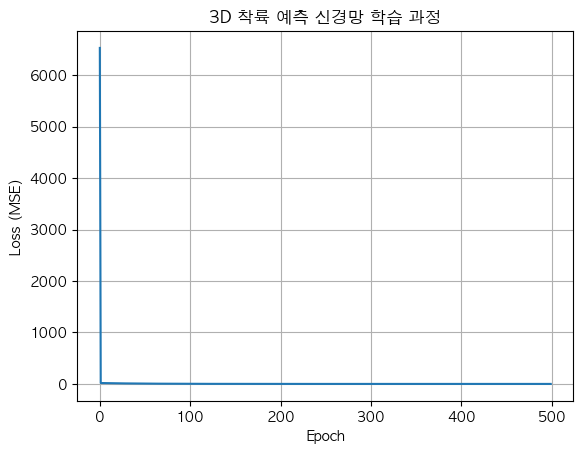

In [8]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정 (예: 맑은 고딕)
plt.rcParams['font.family'] = 'AppleGothic'  # macOS인 경우
# plt.rcParams['font.family'] = 'NanumGothic'  # 설치했을 때
# plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("3D 착륙 예측 신경망 학습 과정")
plt.grid(True)
plt.show()

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


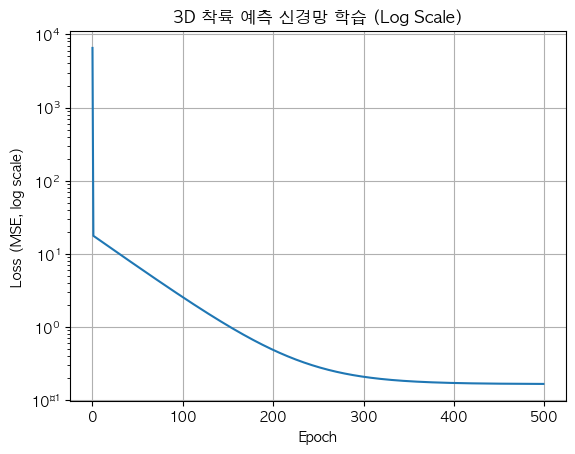

In [ ]:
plt.semilogy(loss_history) #y축에만 로그 적용 
plt.title("3D 착륙 예측 신경망 학습 (Log Scale)")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE, log scale)")
plt.grid(True)
plt.show()

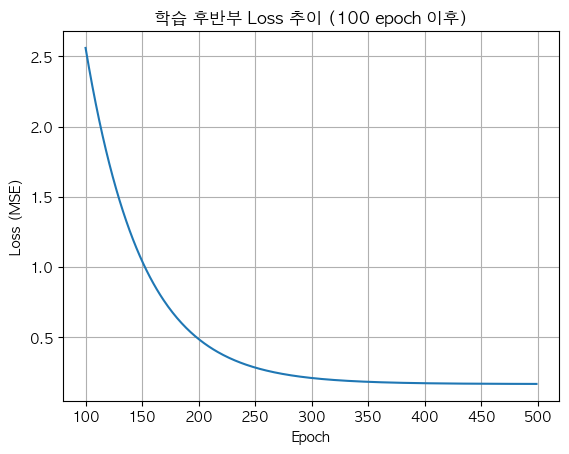

In [11]:
# plt.plot(loss_history[100:]) #후반부 확대 
plt.plot(range(100, 500), loss_history[100:])
plt.title("학습 후반부 Loss 추이 (100 epoch 이후)")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.grid(True)
plt.show()


### 🎁 보너스 미션

- `tanh` 또는 `sigmoid` 활성화 함수로 변경해 보세요.
- 드론의 현재 속도, 풍속, 배터리 잔량 등을 추가 입력 특성으로 확장해보세요.
